In [1]:
import os
import time
import argparse
import numpy as np
from typing import Sequence

from dataset import fetch_data, DataTemplate
from model import LogisticRegression, NNLastLayerIF, MLPClassifier
from utils import fix_seed, save2csv

import json

import pickle
import random

import copy

import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

os.environ["CUDA_VISIBLE_DEVICES"]='0'

from model_softmax_torch import LogisticRegressionMulti, fast_get_inv_hvp_cuda
from modAL.utils.selection import shuffled_argmax, shuffled_argmin

/home/wxxiao/anaconda3/envs/tf-py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Influence Fairness')
    parser.add_argument('--dataset', type=str, default="adult", help="name of the dataset")
    parser.add_argument('--metric', type=str, default="eop", help="eop or dp")
    parser.add_argument('--seed', type=float, default=42, help="random seed")
    parser.add_argument('--save_model', type=str, default="n", help="y/n")
    parser.add_argument('--type', type=str, default="util", help="util/fair/robust")
    parser.add_argument('--strategy', type=str, default="dec", help="inc/dec/random")
    parser.add_argument('--points_to_delete', type=int, default=500, help="points to delete")
    parser.add_argument('--random_seed', type=int, default=42, help="seed for random strategy")
    parser.add_argument('--plot_before_only', type=str, default="n", help="y/n")
    parser.add_argument('--model_type', type=str, default="logreg", help="logreg/nn")
    parser.add_argument('--diabetes', type=str, default="y", help="y/n")

    args = parser.parse_args("--dataset bank --diabetes n --plot_before_only n".split())

    return args
args = parse_args()

In [3]:
def get_full_dataset(args):
    tik = time.time()

    if args.seed is not None:
        fix_seed(args.seed)

    with open('data/' + args.dataset  + '/meta.json', 'r+') as f:
        json_data = json.load(f)
        json_data['train_path'] = './data/' + args.dataset + '/train.csv'
        f.seek(0)        
        json.dump(json_data, f, indent=4)
        f.truncate()

    data: DataTemplate = fetch_data(args.dataset)
    return data


def random_sampling(classifier, X_pool, n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), n_instances, replace=False)
    return query_idx, X_pool[query_idx]



def train_model(args, x_train, y_train, l2_regularlization_term=0.01):
    tik = time.time()

    if args.seed is not None:
        fix_seed(args.seed)

    model = LogisticRegressionMulti(l2_reg=l2_regularlization_term, fit_intercept=True)

    """ vanilla training """

    model.fit(x_train, y_train)

    return model

def train_model_multi(args, x_train, y_train, l2_regularlization_term=0.01):
    tik = time.time()

    if args.seed is not None:
        fix_seed(args.seed)

    model = LogisticRegressionMulti(l2_reg=l2_regularlization_term, fit_intercept=True)

    """ vanilla training """

    model.fit(x_train, y_train)

    return model



def compute_influence(args, x_train, y_train, x_val, y_val, model):
    ori_util_loss_val = model.log_loss(x_val,y_val)

    """ compute the influence and save data """

    pred_train, _ = model.pred(x_train)

    train_total_grad, train_indiv_grad = model.grad(x_train, y_train)
    util_loss_total_grad, acc_loss_indiv_grad = model.grad(x_val, y_val)

    hess = model.hess(x_train)
    util_grad_hvp = model.get_inv_hvp(hess, util_loss_total_grad)

    util_pred_infl = train_indiv_grad.dot(util_grad_hvp)

    return util_pred_infl

In [4]:
args.seed = 0
N_QUERIES = 10 #100
N_ROUNDS = 10

base_model = clf = make_pipeline(StandardScaler(), LogisticRegression(l2_reg=0.01))
#######################
data = get_full_dataset(args)

Loading Bank dataset..
Dataset statistic - #total: 30488; #train: 18292; #val.: 6098; #test: 6098; #dim.: 51



In [5]:
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [7]:
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X_all = wine_quality.data.features 
y_all = wine_quality.data.targets 

X = X_all.iloc[y_all[y_all['quality'] != 9].index].values
y = y_all.iloc[y_all[y_all['quality'] != 9].index].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

X_pool, X_init, y_pool, y_init = train_test_split(X_train, y_train, train_size=X_train.shape[0] - 300, test_size=300, random_state=1, stratify=y_train)

cand_idx = y_all[y_all['quality'] == 9].index
np.random.shuffle(cand_idx.values)

X_pool = np.concatenate((X_pool, X_all.iloc[cand_idx[:2]].values), axis=0)
y_pool = np.concatenate((y_pool, y_all.iloc[cand_idx[:2]].values), axis=0).reshape(-1, )

X_init = np.concatenate((X_init, X_all.iloc[cand_idx[2:3]].values), axis=0)
y_init = np.concatenate((y_init, y_all.iloc[cand_idx[2:3]].values), axis=0).reshape(-1, )

X_val = np.concatenate((X_val, X_all.iloc[cand_idx[3:4]].values), axis=0)
y_val = np.concatenate((y_val, y_all.iloc[cand_idx[3:4]].values), axis=0).reshape(-1, )

X_test = np.concatenate((X_test, X_all.iloc[cand_idx[4:]].values), axis=0)
y_test = np.concatenate((y_test, y_all.iloc[cand_idx[4:]].values), axis=0).reshape(-1, )



le = LabelEncoder()
y_pool = le.fit_transform(y_pool)
y_init = le.transform(y_init)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_pool.reshape(-1, 1))


data.x_val, data.y_val, data.x_test, data.y_test = X_val, y_val, X_test, y_test
X_pool_copy, y_pool_copy = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

X_init.shape, X_pool.shape, X_val.shape, X_test.shape, np.unique(y_test), np.unique(y_val), np.unique(y_pool), np.unique(y_init)

((301, 11),
 (3596, 11),
 (1300, 11),
 (1300, 11),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6]))

In [9]:
C = 50
base_model = make_pipeline(LogisticRegressionMulti(C))

x_init = X_init
x_val = data.x_val
x_test = data.x_test

x_pool = X_pool

x_pool_copy = copy.deepcopy(x_pool)

args.dataset = args.dataset + '_C_' + str(round(C, 2)) + "_No_Scaling" 

data.x_val = x_val
data.x_test = x_test

In [10]:
one_hot_labels_train = enc.transform(y_train.reshape(-1, 1)).toarray()
one_hot_labels_val = enc.transform(y_val.reshape(-1, 1)).toarray()

In [12]:
#Random Sampling
rlearner = ActiveLearner(
estimator=base_model,
query_strategy=random_sampling,
X_training=x_init, y_training=y_init)

unqueried_score = rlearner.score(x_test, data.y_test)
val_score = rlearner.score(x_val, data.y_val)

results_dict = {'random':[unqueried_score], 'entropy':[unqueried_score], 'margin':[unqueried_score], 'influence':[unqueried_score], 'uncertainty':[unqueried_score], 'p_influence':[unqueried_score], 
                'random_val':[val_score], 'entropy_val':[val_score], 'margin_val':[val_score], 'influence_val':[val_score], 'uncertainty_val':[val_score], 'p_influence_val':[val_score]}

for _ in range(N_ROUNDS):
    query_index, query_instance = rlearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    rlearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    rmodel_accuracy = rlearner.score(x_test, data.y_test)
    results_dict['random'].append(rmodel_accuracy)
    results_dict['random_val'].append(rlearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("RANDOM SAMPLING DONE.")
results_dict['random']

RANDOM SAMPLING DONE.


[0.4461538461538462,
 0.43923076923076926,
 0.44153846153846155,
 0.44,
 0.4423076923076923,
 0.44076923076923075,
 0.4423076923076923,
 0.4423076923076923,
 0.44384615384615383,
 0.44769230769230767,
 0.45692307692307693]

In [13]:
#Entropy Sampling
elearner = ActiveLearner(
estimator=base_model,
query_strategy=entropy_sampling,
X_training=x_init, y_training=y_init)


for _ in range(N_ROUNDS):
    query_index, query_instance = elearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    elearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    emodel_accuracy = elearner.score(x_test, data.y_test)
    results_dict['entropy'].append(emodel_accuracy)
    results_dict['entropy_val'].append(elearner.score(x_val, data.y_val))

    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("ENTROPY SAMPLING DONE.")
results_dict['entropy']


ENTROPY SAMPLING DONE.


[0.4461538461538462,
 0.46153846153846156,
 0.45615384615384613,
 0.4546153846153846,
 0.4492307692307692,
 0.4376923076923077,
 0.4376923076923077,
 0.43846153846153846,
 0.4376923076923077,
 0.4453846153846154,
 0.44153846153846155]

In [14]:
#Margin Sampling
mlearner = ActiveLearner(
estimator=base_model,
query_strategy=margin_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = mlearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    mlearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    mmodel_accuracy = mlearner.score(x_test, data.y_test)
    results_dict['margin'].append(mmodel_accuracy)
    results_dict['margin_val'].append(mlearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("MARGIN SAMPLING DONE.")
results_dict['margin']

MARGIN SAMPLING DONE.


[0.4461538461538462,
 0.4530769230769231,
 0.45153846153846156,
 0.4584615384615385,
 0.4684615384615385,
 0.46384615384615385,
 0.47,
 0.47384615384615386,
 0.4746153846153846,
 0.48846153846153845,
 0.47923076923076924]

In [15]:
#Uncertainty Sampling
ulearner = ActiveLearner(
estimator=base_model,
query_strategy=uncertainty_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = ulearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )
    ulearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    umodel_accuracy = ulearner.score(x_test, data.y_test)
    results_dict['uncertainty'].append(umodel_accuracy)
    results_dict['uncertainty_val'].append(ulearner.score(x_val, data.y_val))
    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("UNCERTAINTY SAMPLING DONE.")
results_dict['uncertainty']

UNCERTAINTY SAMPLING DONE.


[0.4461538461538462,
 0.45076923076923076,
 0.45,
 0.44846153846153847,
 0.4338461538461538,
 0.4307692307692308,
 0.4338461538461538,
 0.44153846153846155,
 0.4346153846153846,
 0.4369230769230769,
 0.4430769230769231]

In [16]:
cls_model = train_model(args, X_init, y_init)
util_infl = compute_influence(args, X_init, y_init, data.x_val, data.y_val, cls_model, enc)
estimation_model = DecisionTreeRegressor(random_state=42).fit(X_init, util_infl)
def influence_sampling(classifier, X_pool, n_instances=1):
    I = estimation_model.predict(X_pool)
    query_idx, query_I = shuffled_argmax(I, n_instances=n_instances)
    return query_idx, X_pool[query_idx]

#Influence Sampling
ilearner = ActiveLearner(
estimator=base_model,
query_strategy=influence_sampling,
X_training=x_init, y_training=y_init)

for _ in range(N_ROUNDS):
    query_index, query_instance = ilearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )

    ilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = ilearner.score(x_test, data.y_test)
    results_dict['influence'].append(imodel_accuracy)
    results_dict['influence_val'].append(ilearner.score(x_val, data.y_val))



x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("INFLUENCE SAMPLING DONE.")
results_dict['influence']

/home/wxxiao/anaconda3/envs/tf-py38/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 300/300 [00:00<00:00, 3017.19it/s]


INFLUENCE SAMPLING DONE.


[0.4461538461538462,
 0.4553846153846154,
 0.45153846153846156,
 0.4592307692307692,
 0.46,
 0.4584615384615385,
 0.46307692307692305,
 0.4776923076923077,
 0.48307692307692307,
 0.4815384615384615,
 0.4823076923076923]

In [17]:
def compute_influence_pipeline(args, x_train, y_train, x_val, y_val, model, enc):
    one_hot_labels_val = enc.transform(y_val.reshape(-1, 1)).toarray()
    one_hot_labels_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    # x_train = model[0].transform(x_train)
    # x_val = model[0].transform(x_val)

    logits_val_y = x_val @ model.model.coef_.T + model.model.intercept_
    logits_train_y = x_train @ model.model.coef_.T + model.model.intercept_
    ori_val_loss, ave_ori_val_loss = model.log_loss(logits_val_y, one_hot_labels_val, l2_reg=True)

    train_total_grad, train_indiv_grad = model.grad(x_train, logits_train_y,
                                                    one_hot_labels_train, l2_reg=True)
    val_loss_total_grad, val_loss_indiv_grad = model.grad(x_val, logits_val_y,
                                                        one_hot_labels_val, l2_reg=True)

    hess = model.hess_cuda(x_train, logits_train_y)

    loss_grad_hvp = fast_get_inv_hvp_cuda(hess, val_loss_total_grad.T, cholskey=False).cpu().numpy()
    pred_infl = train_indiv_grad.dot(loss_grad_hvp)

    return pred_infl

In [18]:
def p_inf_sampling(classifier, X_pool, n_instances=1):
    p_labels = pilearner.predict(X_pool)
    pool_infl = compute_influence_pipeline(args, X_pool, p_labels, data.x_val, data.y_val, pilearner.estimator[0], enc)
    query_idx, query_I = shuffled_argmax(pool_infl, n_instances=n_instances)
    return query_idx, X_pool[query_idx]

#P Influence Sampling
pilearner = ActiveLearner(
estimator=base_model,
query_strategy=p_inf_sampling,
X_training=x_init, y_training=y_init)

results_dict['p_influence'] = [unqueried_score]
results_dict['p_influence_val'] =  [val_score]


for _ in range(N_ROUNDS):
    query_index, query_instance = pilearner.query(x_pool, n_instances=N_QUERIES)

    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), y_pool[query_index].reshape(N_QUERIES, )

    pilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = pilearner.score(x_test, data.y_test)
    results_dict['p_influence'].append(imodel_accuracy)
    results_dict['p_influence_val'].append(pilearner.score(x_val, data.y_val))

x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("INFLUENCE SAMPLING DONE.")
results_dict['p_influence']

  5%|▌         | 190/3595 [00:00<00:01, 1898.45it/s]

100%|██████████| 3586/3586 [00:01<00:00, 3126.26it/s]


INFLUENCE SAMPLING DONE.


[0.4461538461538462,
 0.44,
 0.4369230769230769,
 0.4269230769230769,
 0.45076923076923076,
 0.4423076923076923,
 0.44,
 0.43923076923076926,
 0.42,
 0.43153846153846154,
 0.43538461538461537]

In [19]:
def compute_influence_pipeline_auto(args, x_train, y_train, x_val, y_val, model, enc):
    one_hot_labels_val = enc.transform(y_val.reshape(-1, 1)).toarray()
    
    
    # x_train = model[0].transform(x_train)
    # x_val = model[0].transform(x_val)

    logits_train_y = x_train @ model.model.coef_.T + model.model.intercept_
    logits_val_y = x_val @ model.model.coef_.T + model.model.intercept_
    print(logits_val_y.shape, one_hot_labels_val.shape)
    ori_val_loss, ave_ori_val_loss = model.log_loss(logits_val_y, one_hot_labels_val, l2_reg=True)

    val_loss_total_grad, val_loss_indiv_grad = model.grad(x_val, logits_val_y,
                                                        one_hot_labels_val, l2_reg=True)
    hess = model.hess_cuda(x_train, logits_train_y)

    loss_grad_hvp = fast_get_inv_hvp_cuda(hess, val_loss_total_grad.T, cholskey=False).cpu().numpy()

    results = {}
    for i in np.unique(y_val):
        one_hot_labels_train = enc.transform(np.ones_like(y_train).reshape(-1, 1)*i).toarray()
        logits_train_y = x_train @ model.model.coef_.T + model.model.intercept_
        _, train_indiv_grad = model.grad(x_train, logits_train_y,
                                                    one_hot_labels_train, l2_reg=True)
        pred_infl = train_indiv_grad.dot(loss_grad_hvp)
        results[i] = pred_infl.reshape(-1,)
        # print(i)
    return results

In [20]:
np.unique(y_init).shape

(7,)

In [21]:

def auto_inf_sampling(classifier, X_pool, n_instances=1):
    
    res =  compute_influence_pipeline_auto(args, X_pool, np.zeros(shape=(X_pool.shape[0],)), data.x_val, data.y_val, auto_l_ilearner.estimator[0], enc)
    res = pd.DataFrame.from_dict(res)
    query_metrics = res.idxmax(axis=1).values

    res['max'] = res.max(axis=1)
    res['min'] = res.min(axis=1)
    res['diff'] = res['max'] - res['min']
    
    query_idx, query_I = shuffled_argmax(res['max'].values, n_instances=n_instances)

    return query_idx, query_metrics[query_idx]


auto_l_ilearner = ActiveLearner(
estimator=base_model,
query_strategy=auto_inf_sampling,
X_training=x_init, y_training=y_init)

def auto_inf_sampling(classifier, X_pool, n_instances=1):
    
    res =  compute_influence_pipeline_auto(args, X_pool, np.zeros(shape=(X_pool.shape[0],)), data.x_val, data.y_val, auto_l_ilearner.estimator[0], enc)
    res = pd.DataFrame.from_dict(res)
    query_metrics = res.idxmax(axis=1).values

    res['max'] = res.max(axis=1)
    res['min'] = res.min(axis=1)
    res['diff'] = res['max'] - res['min']
    
    query_idx, query_I = shuffled_argmax(res['max'].values, n_instances=n_instances)

    return query_idx, query_metrics[query_idx]

results_dict['a_influence'] = [unqueried_score]
results_dict['a_influence_val'] = [val_score]

for _ in range(N_ROUNDS):
    query_index, query_instance, auto_labels = auto_l_ilearner.query(x_pool, n_instances=N_QUERIES, return_metrics=True)

    # print(list(zip(inf_0_1, y_pool[query_index], np.where(np.array(inf_0_1)>0, 1, 0).reshape(N_QUERIES, ))))
    x_teach, y_teach = x_pool[query_index].reshape(N_QUERIES, -1), auto_labels.reshape(N_QUERIES, )

    auto_l_ilearner.teach(X=x_teach, y=y_teach)

    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    imodel_accuracy = auto_l_ilearner.score(x_test, data.y_test)
    results_dict['a_influence'].append(imodel_accuracy)
    results_dict['a_influence_val'].append(auto_l_ilearner.score(x_val, data.y_val))
    
x_pool, y_pool = copy.deepcopy(x_pool_copy), copy.deepcopy(y_pool_copy)

print("auto INFLUENCE SAMPLING DONE.")
results_dict['a_influence']

(1300, 7) (1300, 7)


 23%|██▎       | 837/3595 [00:00<00:00, 2912.56it/s]

100%|██████████| 3595/3595 [00:01<00:00, 2718.84it/s]


(1300, 7) (1300, 7)


100%|██████████| 3585/3585 [00:01<00:00, 2929.93it/s]


(1300, 7) (1300, 7)


100%|██████████| 3575/3575 [00:01<00:00, 2971.41it/s]


(1300, 7) (1300, 7)


100%|██████████| 3565/3565 [00:01<00:00, 2954.03it/s]


(1300, 7) (1300, 7)


100%|██████████| 3555/3555 [00:01<00:00, 2919.89it/s]


(1300, 7) (1300, 7)


100%|██████████| 3545/3545 [00:01<00:00, 2927.09it/s]


(1300, 7) (1300, 7)


100%|██████████| 3535/3535 [00:01<00:00, 2944.94it/s]


(1300, 7) (1300, 7)


100%|██████████| 3525/3525 [00:01<00:00, 2989.54it/s]


(1300, 7) (1300, 7)


100%|██████████| 3515/3515 [00:01<00:00, 3053.16it/s]


(1300, 7) (1300, 7)


100%|██████████| 3505/3505 [00:01<00:00, 3025.50it/s]


auto INFLUENCE SAMPLING DONE.


[0.4461538461538462,
 0.44461538461538463,
 0.4469230769230769,
 0.4546153846153846,
 0.46153846153846156,
 0.47846153846153844,
 0.48846153846153845,
 0.49,
 0.4938461538461538,
 0.49846153846153846,
 0.5046153846153846]

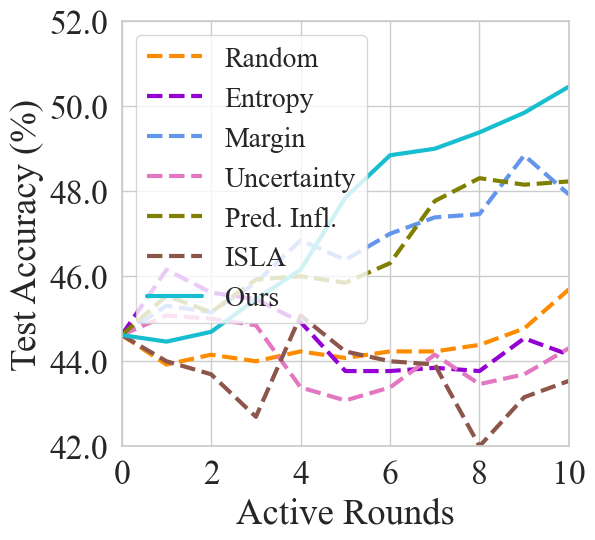

In [24]:
import seaborn as sns
sns.set(font_scale=2.2)

sns.set_style("whitegrid")
plt.figure(figsize=(6.55, 6))
plt.rcParams["font.family"] = "Times New Roman"

args.dataset = 'wine_quality'
# plt.plot(range(11), results_dict['random'], label='Random', color='tab:orange', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['random'], label='Random', color='darkorange', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['entropy'], label='Entropy', color='darkviolet', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['margin'], label='Margin', color='cornflowerblue', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['uncertainty'], label='Uncertainty', color='tab:pink', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['influence'], label='Pred. Infl.', color='olive', linestyle='dashed',lw=3)
plt.plot(range(11), results_dict['p_influence'], label='ISLA', color='tab:brown', linestyle='dashed',lw=3)
# plt.plot(range(11), results_dict['diff_influence'], label='Influence w/o Auto-Labeling', linestyle='dashed', color='tab:red', lw=3)
plt.plot(range(11), results_dict['a_influence'], label='Ours', color='tab:cyan', lw=3)
# plt.plot(range(11), results_dict['r_influence'], label='Auto-Labeling Reversed Influence', color='darkviolet', lw=3)


plt.xlabel('Active Rounds')
plt.ylabel('Test Accuracy (%)')
legend = plt.legend(loc="upper left", fontsize=20)
legend.get_frame().set_alpha(0.8)

# plt.title(args.dataset + ' Test Dataset')
# tight layout
plt.ylim(0.42, 0.52)
plt.yticks(np.linspace(0.42, 0.52, num=6), np.linspace(0.42, 0.52, num=6)*100)
plt.xlim(0, 10)
plt.xticks(range(0, 11, 2))
plt.tight_layout()
savename = 'newresults/'+ args.dataset + '_test_' + str(C) +'_influence_sampling.png'
plt.savefig(savename, dpi=300)
plt.show()